In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, map_coordinates
from skimage.transform import probabilistic_hough_line
from mpl_toolkits.mplot3d import Axes3D
import math
import cv2

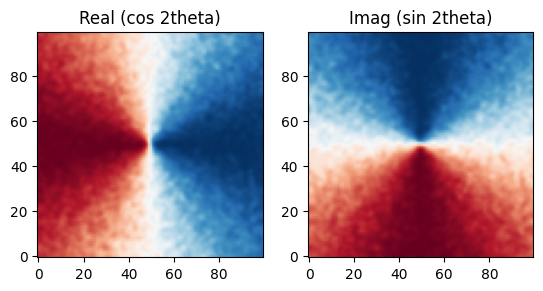

In [ ]:
neurons = 100
x, y = np.linspace(0,neurons,neurons), np.linspace(0,neurons,neurons)
X, Y = np.meshgrid(x,y)

xo, yo = neurons/2, neurons/2
theta = 0.5 * np.arctan2(Y-yo, X-xo)

Z = np.exp(1j * 2 *theta)
noise_std = np.radians(5)
Z *= np.exp(1j * 2 *np.random.normal(0, noise_std, Z.shape))

Z_real = gaussian_filter(Z.real, sigma = 1)
Z_imag = gaussian_filter(Z.imag, sigma = 1)
Z_field = Z_real + 1j * Z_imag



plt.subplot(1, 2, 1)
plt.imshow(Z_field.real, cmap='RdBu', origin='lower')
plt.title('Real (cos 2theta)')

plt.subplot(1, 2, 2)
plt.imshow(Z_field.imag, cmap='RdBu', origin='lower')
plt.title('Imag (sin 2theta)')

plt.show()

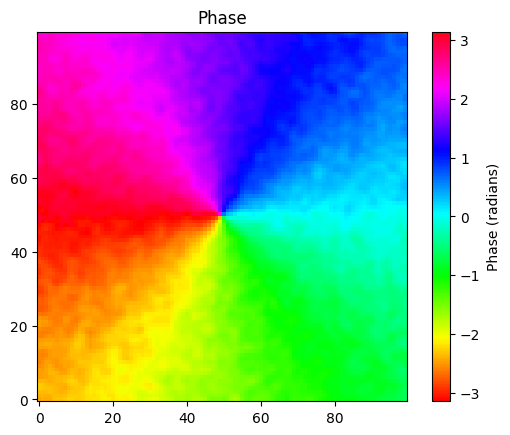

In [ ]:
plt.imshow(np.angle(Z_field), cmap='hsv', origin='lower')
plt.colorbar(label='Phase (radians)')
plt.title('Phase')
plt.show()


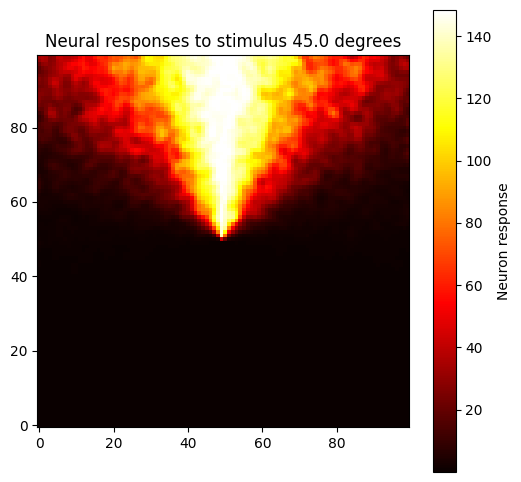

In [ ]:
stimulus_orientation = np.pi/4

kappa = 5
R_max = 1

preferred_orientations = np.angle(Z_field) / 2
response_map = np.zeros_like(preferred_orientations)

R0 = 0.0
for i in range(Z_field.shape[0]):
  for j in range(Z_field.shape[1]):
    preference = preferred_orientations[i,j]
    delta_pref = stimulus_orientation - preference
    response_map[i, j] = R0 + R_max * np.exp(kappa * np.cos(2 * delta_pref))

plt.figure(figsize=(6,6))
plt.imshow(response_map, cmap='hot', origin='lower')
plt.colorbar(label='Neuron response')
plt.title(f'Neural responses to stimulus {np.degrees(stimulus_orientation)} degrees')
plt.show()

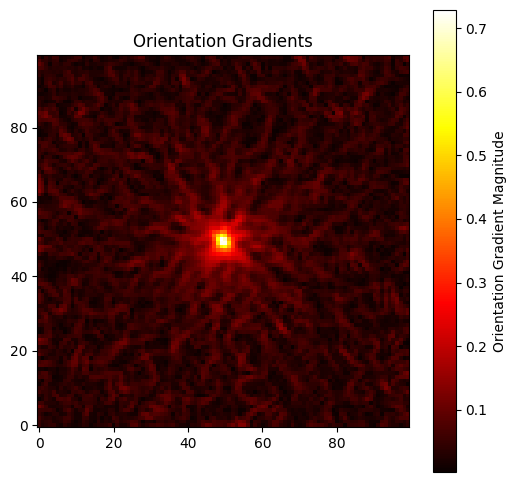

In [ ]:
dtheta_x, dtheta_y = np.gradient(Z_field)
gradient_magnitude = np.sqrt(np.abs(dtheta_x)**2 + np.abs(dtheta_y)**2)

plt.figure(figsize = (6,6))
plt.imshow(gradient_magnitude, cmap = 'hot', origin = 'lower')
plt.colorbar(label='Orientation Gradient Magnitude')
plt.title('Orientation Gradients')
plt.show()

In [ ]:
# num_stimuli = 5


# theta_grid = np.linspace(0, np.pi , num_stimuli, endpoint = False)
# preferred_theta = np.pi/4
# kappa_prior = 5.0
# prior = np.exp(kappa_prior * np.cos(2 * (theta_grid - preferred_theta)))
# prior /= prior.sum()

# stimulus_orientations = np.random.choice(
#     theta_grid,
#     size=num_stimuli,
#     p=prior
# )


# distance = np.sqrt((X-xo)**2 + (Y-yo)**2)
# runs = 1
# FI_runs = []

# for run in range(runs):

#   FI_total = np.zeros_like(preferred_orientations)

#   for theta_stim in stimulus_orientations:
#     R = R0 + np.exp(kappa * (np.cos(2*(preferred_orientations - theta_stim)) - 1))
#     dr_dtheta = -2 * kappa * np.sin(2*(preferred_orientations - theta_stim)) * R
#     FI = (dr_dtheta**2) / (R + 1e-12)
#     FI_total += FI

#   FI_avg = FI_total / num_stimuli


#   FI_runs.append(FI_avg)

# FI_runs = np.array(FI_runs)



In [ ]:
# print(FI_avg.shape)
# print(FI_runs.shape)
# print(FI_total.shape)
# print(np.max(distance))

In [ ]:
# FI_mean = FI_runs.mean(axis = 0)
# FI_std = FI_runs.std(axis = 0)



In [ ]:
# R_maps = []
# for ori in stimulus_orientations:
#     current_R_map = R0 + np.exp(kappa * (np.cos(2*(preferred_orientations - ori)) - 1))
#     R_maps.append(current_R_map)
# R_map = np.mean(R_maps, axis=0)

# plt.figure(figsize=(10, 4))
# plt.subplot(1,2,1)
# plt.imshow(FI_mean, cmap='viridis', origin='lower')
# # plt.scatter([xo], [yo], color='red', s=50, label='Pinwheel Center')
# plt.colorbar(label='Average FI')
# plt.title('2D Fisher Information')
# plt.legend()


# plt.subplot(1,2,2)
# plt.imshow(R_map, cmap='plasma', origin='lower')
# plt.colorbar(label='Firing rate (von Mises)')
# plt.title('2D Average Von Mises Tuning Responses')
# plt.axis('equal')
# plt.legend()
# plt.tight_layout()
# plt.show()


# fig = plt.figure(figsize=(8,6))
# ax = fig.add_subplot(111, projection='3d')
# X_grid, Y_grid = np.meshgrid(np.arange(neurons), np.arange(neurons))
# surf = ax.plot_surface(X_grid, Y_grid, FI_mean, cmap='viridis', edgecolor='k', alpha=0.9)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Fisher Information')
# ax.set_title('3D FI')
# fig.colorbar(surf, ax=ax, shrink=0.5, label='FI')
# plt.show()

In [ ]:
# center_radius = 1
# surround_radius = 5

# center_mask = distance < center_radius
# surround_mask = (distance < surround_radius) & (distance >= center_radius)


# FI_center = np.mean(FI_mean[center_mask])
# FI_surround = np.mean(FI_mean[surround_mask])

# Delta_FI = FI_surround - FI_center
# Delta_FI_norm = Delta_FI / FI_surround

# print("FI center:", FI_center)
# print("FI surround:", FI_surround)
# print("Delta FI:", Delta_FI)
# print("Normalized Delta FI:", Delta_FI_norm)

# Ratio = FI_center/FI_surround
# print(Ratio)

In [ ]:
def FI_map(stimulus_orientations, preferred_orientations = preferred_orientations, xo=xo, yo=yo, ro= 0, kappa = 5):

  FI_total = np.zeros_like(preferred_orientations)

  for theta_stim in stimulus_orientations:
    R = R0 + np.exp(kappa * (np.cos(2*(preferred_orientations - theta_stim)) - 1))
    dr_dtheta = -2 * kappa * np.sin(2*(preferred_orientations - theta_stim)) * R
    FI = (dr_dtheta**2) / (R + 1e-12)
    FI_total += FI

  FI_avg = FI_total / N

  return FI_avg[int(xo),int(yo)]

N_values = np.unique(np.logspace(0, 2.5, 15).astype(int))
num_trials = 30
FI_center_mean = []
FI_center_var = []


for N in N_values:
    FI_samples = []

    theta_grid = np.linspace(0, np.pi , N, endpoint = False)
    preferred_theta = np.pi/4
    prior = np.exp(kappa * np.cos(2 * (theta_grid - preferred_theta)))
    prior /= prior.sum()

    for trial in range(num_trials):

        stimulus_orientations = np.random.choice(
            theta_grid,
            size=N,
            replace=True
        )

        # stimulus_orientations = np.linspace(0, np.pi , N, endpoint = False)


        FI0 = FI_map(
            stimulus_orientations,
            preferred_orientations,
            xo, yo,
            R0, kappa
        )

        FI_samples.append(FI0)

    FI_samples = np.array(FI_samples)

    FI_center_mean.append(FI_samples.mean())
    FI_center_var.append(FI_samples.var())

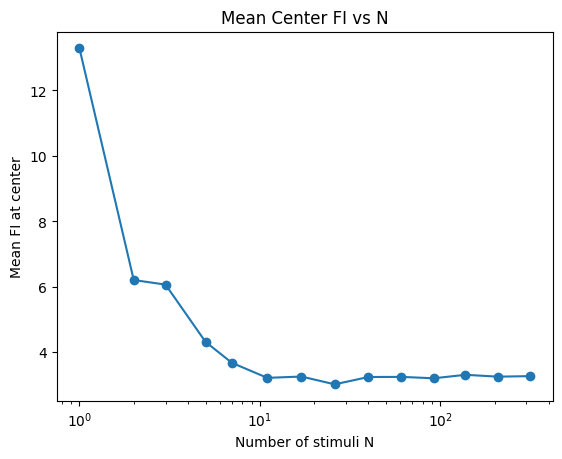

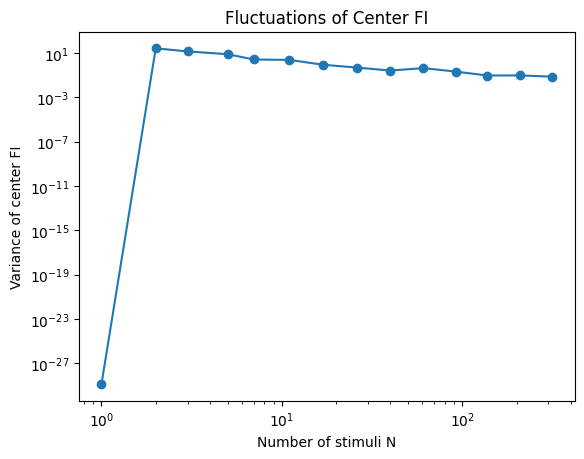

In [ ]:
plt.figure()
plt.plot(N_values, FI_center_mean, 'o-')
plt.xscale('log')
plt.xlabel('Number of stimuli N')
plt.ylabel('Mean FI at center')
plt.title('Mean Center FI vs N')
plt.show()

plt.figure()
plt.plot(N_values, FI_center_var, 'o-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of stimuli N')
plt.ylabel('Variance of center FI')
plt.title('Fluctuations of Center FI')
plt.show()
